In [11]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np 
from sklearn.cluster import KMeans
from scipy import stats

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from utils.network_analysis import *
from utils.neural_embedding import *

## **1. Read embeddings vectors**

The output of the neural embedding process will be a dictionary object of structure {'username' : np.array} where np.array is an $n$-dimensional vector representing the embedding (in $n$-dimensional embedding space)

In [12]:
embeddings_path = 'data/processed/embedding_senate_kout1_kin2_20.pkl'

with open(embeddings_path, "rb") as input_file:
   embeddings_dct = pickle.load(input_file)

## **2. Compute and plot Principal Components vectors**

#### 2.1 Compute Principal Components

In [3]:
def computePCA(embedding_dict, n=2):
    """Compute n Principal components of sample data. 
    
    Args:
        - embedding_dct (dict) : Dictionary of sample names and feature vector, of structure {'name' : np.array}
        - n (int) : Number of Principal components to calculate

    Returns:
        - pca_dict (dct) : Dictionary of sample names and feature vector of principcal components, of structure {'name' : np.array}. Dim of np.array = n
    """
    # Extract names and vectors
    names = list(embedding_dict.keys())
    vectors = np.array(list(embedding_dict.values()))

    # Perform PCA
    pca = PCA(n_components=n)
    reduced_vectors = pca.fit_transform(vectors)

    # Create a new dictionary with the reduced vectors
    pca_dict = {name: reduced_vectors[i] for i, name in enumerate(names)}

    return pca_dict

#### 2.2 Plot Principal Components

In [4]:
def plotPCA(pca_dict, democrats, republicans):
    """Plot up to 2 principcal components of PCA vectors (or 1 if only 1 available)
    
    Args:
        - pca_dct (dict) : Dictionary of sample names and feature vector of principcal components, of structure {'name' : np.array}

    Returns:
        - pca_dct_reduced (dict) : pca_dct reduce to <=2 principcal components (the vector being plotted). Returns pca_dct if <=2 already.
    """

    # If more than 2 components, reduce to 2 components for plotting
    n_components = len(list(pca_dict.values())[0])
    pca_dict_reduced = pca_dict.copy()
    if n_components > 2:
        print(f'Reducing {n_components} principal components to 2')
        for i in pca_dict_reduced:
            pca_dict_reduced[i] = pca_dict_reduced[i][:2]


    democrats_dict = {}
    republicans_dict = {}

    for congressperson in pca_dict:
        if congressperson in democrats:
            democrats_dict[congressperson] = pca_dict[congressperson]
        elif congressperson in republicans:
            republicans_dict[congressperson] = pca_dict[congressperson]

    with plt.style.context("ggplot"):
        # Plotting the 2D vectors
        plt.figure(figsize=(7, 5))

        if n_components == 1:
            for name, vector in democrats_dict.items():
                plt.scatter(vector[0], 0, label='democrat', color='navy')
            for name, vector in republicans_dict.items():
                plt.scatter(vector[0], 0, label='republican', color='red')
                #plt.annotate(name, (vector[0], 0))
        else:
            for name, vector in democrats_dict.items():
                plt.scatter(vector[0], vector[1], label='democrat', color='navy')
            for name, vector in republicans_dict.items():
                plt.scatter(vector[0], vector[1], label='republican', color='red')
                #plt.annotate(name, (vector[0], vector[1]))

        plt.title('Embeddings: PCA Components 1 and 2', size=10)
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        #plt.legend()
        plt.grid(True)
        plt.show()

    return pca_dict_reduced

def computeKMeans(data_dict, k=2):
    # Convert the dictionary values to a NumPy array
    features = np.array(list(data_dict.values()))

    # Initialize and fit the KMeans algorithm
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(features)

    # Get the cluster labels
    labels = kmeans.labels_

    # If you want to associate labels with the original names:
    labeled_data = dict(zip(data_dict.keys(), labels))

    # Plotting
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 5))
        colors = ['red', 'navy',]  # Extend this list for more clusters

        for i in range(k):
            # Plot data points that are assigned to each cluster
            plt.scatter(features[labels == i, 0], features[labels == i, 1], s=50, c=colors[i], label=f'Cluster {i}')

        plt.title('Cluster visualization')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        plt.grid(True)
        plt.show()

    return labeled_data

In [5]:
# Read in congressmember to party mapping table
filepath = 'data/raw/congressmembers_characteristics.csv'
all_congress_members = pd.read_csv(filepath).drop_duplicates('twitter_name')

democrats = all_congress_members[all_congress_members['party'] == 'D']
republicans = all_congress_members[all_congress_members['party'] == 'R']

democrats_congress_members = list(democrats['congressperson'])
republicans_congress_members = list(republicans['congressperson'])

house_list = list(all_congress_members[all_congress_members['chamber'] == 'House']['congressperson'])
senate_list = list(all_congress_members[all_congress_members['chamber'] == 'Senate']['congressperson'])

In [16]:
embeddings_dct_house = {key:value for key,value in embeddings_dct.items() if key in house_list}
embeddings_dct_senate = {key:value for key,value in embeddings_dct.items() if key in senate_list}

In [15]:
# Compute first 2 principal components
pca_dict_house = computePCA(embeddings_dct, 2)
#pca_dict_senate = computePCA(embeddings_dct_senate, 2)

In [257]:
def plotPCA(pca_dict, democrats, republicans, ax):
    kin_kout = pca_dict[1]
    pca_dict = pca_dict[0]
    n_components = len(list(pca_dict.values())[0])
    pca_dict_reduced = pca_dict.copy()
    if n_components > 2:
        print(f'Reducing {n_components} principal components to 2')
        for i in pca_dict_reduced:
            pca_dict_reduced[i] = pca_dict_reduced[i][:2]

    democrats_dict = {}
    republicans_dict = {}

    for congressperson in pca_dict:
        if congressperson in democrats:
            democrats_dict[congressperson] = pca_dict[congressperson]
        elif congressperson in republicans:
            republicans_dict[congressperson] = pca_dict[congressperson]

    with plt.style.context("ggplot"):
        if n_components == 1:
            for name, vector in democrats_dict.items():
                ax.scatter(vector[0], 0, label='Democrat', color='navy')
            for name, vector in republicans_dict.items():
                ax.scatter(vector[0], 0, label='Republican', color='red')
        else:
            for name, vector in democrats_dict.items():
                ax.scatter(vector[0], vector[1], label='Democrat', color='navy')
            for name, vector in republicans_dict.items():
                ax.scatter(vector[0], vector[1], label='Republican', color='red')

        ax.set_title(f'PCA Components 1 and 2 ({kin_kout})', size=10)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        #ax.legend()
        ax.grid(True)

def plotPC1vsDW(pca_dict, democrats, republicans, chamber,ax):
    kin_kout = pca_dict[1]
    pca_dict = pca_dict[0]
    first_pca_df = pd.DataFrame.from_dict(pca_dict, orient='index').reset_index().rename(columns = {'index' : 'congressperson', 0 : 'first_pc'})


    democrats = democrats.merge(first_pca_df, on='congressperson', how='left')
    republicans = republicans.merge(first_pca_df, on='congressperson', how='left')
    democrats = democrats[democrats['chamber'] == chamber].dropna(subset=['first_pc'])
    republicans = republicans[republicans['chamber'] == chamber].dropna(subset=['first_pc'])


    with plt.style.context("ggplot"):
        x1 = democrats['DW-Nominate']
        y1 = democrats['first_pc']

        x2 = republicans['DW-Nominate']
        y2 = republicans['first_pc']
        
        ax.scatter(x1,y1, label='democrats', color='navy')
        ax.scatter(x2, y2, label='republicans', color='red')

        ax.set_title(f'PC1 vs. DW-Nominate score({kin_kout})', size=10)
        ax.set_xlabel('DW-Nominate')
        ax.set_ylabel('PC1')
        #ax.legend()
        ax.grid(True)

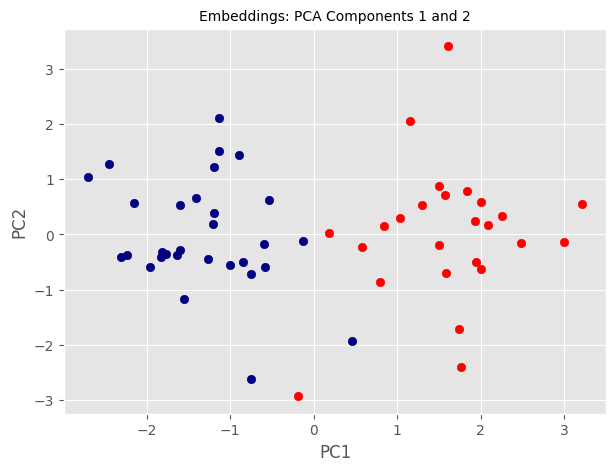

In [16]:
rd = plotPCA(pca_dict_house,democrats_congress_members , republicans_congress_members)

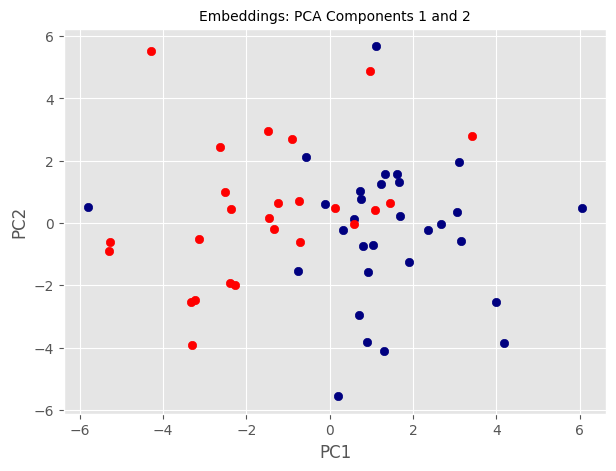

In [20]:
rd = plotPCA(pca_dict_senate,democrats_congress_members , republicans_congress_members)

## **3. Compare first principcal component to DW-Nominate score**

In [17]:
first_pca = computePCA(embeddings_dct, 1)
first_pca_df = pd.DataFrame.from_dict(first_pca, orient='index').reset_index().rename(columns = {'index' : 'congressperson', 0 : 'first_pc'})

In [18]:
democrats_house = democrats.merge(first_pca_df, on='congressperson', how='left')
republicans_house = republicans.merge(first_pca_df, on='congressperson', how='left')

democrats_house = democrats_house[democrats_house['chamber'] == 'House'].dropna(subset=['first_pc'])
republicans_house = republicans_house[republicans_house['chamber'] == 'House'].dropna(subset=['first_pc'])

In [19]:
with plt.style.context("ggplot"):



    plt.figure(figsize=(11,7))

    x1 = democrats_house.dropna(subset=['dw.nom.1'])['dw.nom.1']
    y1 = democrats_house.dropna(subset=['dw.nom.1'])['first_pc']
    nancy = democrats_house[democrats_house['congressperson'] == 'speakerpelosi']
    nancy_x = nancy['dw.nom.1']
    nancy_y = nancy['first_pc']
    democrat_corr = np.round(stats.pearsonr(x1,y1).statistic,2)

    x2 = republicans_house.dropna(subset=['dw.nom.1'])['dw.nom.1']
    y2 = republicans_house.dropna(subset=['dw.nom.1'])['first_pc']
    republican_corr = np.round(stats.pearsonr(x2,y2).statistic,2)

    all_x = pd.concat([x1,x2])
    all_y = pd.concat([y1, y2])
    all_corr = np.round(stats.pearsonr(all_x, all_y).statistic,2)

    
    plt.scatter(x1,y1, label='Democrats', color='navy', marker=r'$D$')
    plt.scatter(x2, y2, label='Republicans', color='red', marker=r'$R$')
    plt.scatter(nancy_x,nancy_y, color='green', marker='o', s=80, label='Nancy Pelosi')
    plt.annotate(r'$\rho_D$={}'.format(democrat_corr), (-0.6,3.3), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))
    plt.annotate(r'$\rho_R$={}'.format(republican_corr), (1,1), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))
    plt.annotate(r'$\rho_{{All}}$={}'.format(all_corr), (0,-1.5), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))

    plt.axvline(x=0, color='grey', linestyle='dashed')
    plt.axhline(y=0, color='grey', linestyle='dashed')

    plt.xlabel('DW-Nominate score')
    plt.ylabel('PC1 (Opinion Score)')
    plt.title('PC1 of embedding vs. Ground-truth DW-Nominate (Actual)', size=10)
    plt.legend()
    plt.show()

ValueError: x and y must have length at least 2.

## **4. Compare rankings by method**

In [30]:
all_house = pd.concat([democrats_house, republicans_house])
all_house['DW-Nominate_rank'] = all_house['dw.nom.1'].rank(ascending=True)
all_house['first_pc_rank'] = all_house['first_pc'].rank(ascending=True)

democrats_house_ranked = all_house[all_house['party'] == 'D']
republicans_house_ranked = all_house[all_house['party'] == 'R']

In [31]:
with plt.style.context("ggplot"):

    plt.figure(figsize=(11,7))
    
    x1 = democrats_house_ranked['DW-Nominate_rank']
    y1 = democrats_house_ranked['first_pc_rank']
    democrat_rank_corr = np.round(stats.pearsonr(x1,y1).statistic,2)

    x2 = republicans_house_ranked['DW-Nominate_rank']
    y2 = republicans_house_ranked['first_pc_rank']
    republican_rank_corr = np.round(stats.pearsonr(x1,y1).statistic,2)

    all_rank_x = pd.concat([x1,x2])
    all_rank_y = pd.concat([y1, y2])
    all_rank_corr = np.round(stats.pearsonr(all_rank_x, all_rank_y).statistic,2)
    
    plt.scatter(x1,y1, label='democrats', color='navy', marker=r'$D$')
    plt.scatter(x2, y2, label='republicans', color='red', marker=r'$R$')

    plt.annotate(r'$\rho_D$={}'.format(democrat_rank_corr), (45,100), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))
    plt.annotate(r'$\rho_R$={}'.format(republican_rank_corr), (90,65), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))
    plt.annotate(r'$\rho_{{All}}$={}'.format(all_rank_corr), (30,40), fontsize=14, bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="black"))


    plt.xlabel('DW-Nominate ranking')
    plt.ylabel('PC1 ranking')
    plt.title('PC1 of embedding vs. Ground-truth DW-Nominate (ranking)', size=10)
    plt.legend()
    plt.show()

ValueError: array must not contain infs or NaNs